In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import gradio as gr

# Food Delivery Rating Predictor

# Problem Statement
We want to predict whether a customer will give a high or low rating for their food delivery based on estimated delivery time, price, distance, and order details.

In [109]:
# ! pip install gradio

In [110]:
df = pd.read_csv('order_history_kaggle_data.csv')

## exploration

In [111]:
df.head(5)

,Restaurant ID,Restaurant name,Subzone,City,Order ID,Order Placed At,Order Status,Delivery,Distance,Items in order,...,Rating,Review,Cancellation / Rejection reason,Restaurant compensation (Cancellation),Restaurant penalty (Rejection),KPT duration (minutes),Rider wait time (minutes),Order Ready Marked,Customer complaint tag,Customer ID
0,20320607,Swaad,Sector 4,Delhi NCR,6168884918,"11:38 PM, September 10 2024",Delivered,Zomato Delivery,3km,"1 x Grilled Chicken Jamaican Tender, 1 x Grill...",...,NaN,NaN,NaN,NaN,NaN,18.35,11.6,Correctly,NaN,5d6c2b96db963098bc69768bea504c8bf46106a8a5178e...
1,20320607,Swaad,Sector 4,Delhi NCR,6170707559,"11:34 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Peri Peri Fries, 1 x Fried Chicken Angara ...",...,NaN,NaN,NaN,NaN,NaN,16.95,3.6,Correctly,NaN,0781815deb4a10a574e9fee4fa0b86b074d4a0b36175d5...
2,20320607,Swaad,Sector 4,Delhi NCR,6169375019,"03:52 PM, September 10 2024",Delivered,Zomato Delivery,<1km,1 x Bone in Peri Peri Grilled Chicken,...,NaN,NaN,NaN,NaN,NaN,14.05,12.2,Correctly,NaN,f93362f5ce5382657482d164e368186bcec9c6225fd93d...
3,20320607,Swaad,Sector 4,Delhi NCR,6151677434,"03:45 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Fried Chicken Ghostbuster Tender, 1 x Anga...",...,4.0,NaN,NaN,NaN,NaN,19.00,3.3,Correctly,NaN,1ed226d1b8a5f7acee12fc1d6676558330a3b2b742af5d...
4,20320607,Swaad,Sector 4,Delhi NCR,6167540897,"03:04 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Peri Peri Krispers, 1 x Fried Chicken Anga...",...,NaN,NaN,NaN,NaN,NaN,15.97,1.0,Correctly,NaN,d21a2ac6ea06b31cc3288ab20c4ef2f292066c096f2c5f...


In [112]:
df.isna().sum()

Restaurant ID                                             0
Restaurant name                                           0
Subzone                                                   0
City                                                      0
Order ID                                                  0
Order Placed At                                           0
Order Status                                              0
Delivery                                                  0
Distance                                                  0
Items in order                                            0
Instructions                                          20601
Discount construct                                     5498
Bill subtotal                                             0
Packaging charges                                         0
Restaurant discount (Promo)                               0
Restaurant discount (Flat offs, Freebies & others)        0
Gold discount                           

In [113]:
df.columns

Index(['Restaurant ID', 'Restaurant name', 'Subzone', 'City', 'Order ID',
       'Order Placed At', 'Order Status', 'Delivery', 'Distance',
       'Items in order', 'Instructions', 'Discount construct', 'Bill subtotal',
       'Packaging charges', 'Restaurant discount (Promo)',
       'Restaurant discount (Flat offs, Freebies & others)', 'Gold discount',
       'Brand pack discount', 'Total', 'Rating', 'Review',
       'Cancellation / Rejection reason',
       'Restaurant compensation (Cancellation)',
       'Restaurant penalty (Rejection)', 'KPT duration (minutes)',
       'Rider wait time (minutes)', 'Order Ready Marked',
       'Customer complaint tag', 'Customer ID'],
      dtype='object')

In [114]:
df.shape

(21321, 29)

##--------------------

In [115]:
to_predict = [
    'Distance',
    'Items in order',
    'Bill subtotal',
    'Total',
    'KPT duration (minutes)',
    'Rider wait time (minutes)'
]

In [116]:
df[to_predict].isna().sum()

Distance                       0
Items in order                 0
Bill subtotal                  0
Total                          0
KPT duration (minutes)       295
Rider wait time (minutes)    168
dtype: int64

In [117]:
df[to_predict].describe()

,Bill subtotal,Total,KPT duration (minutes),Rider wait time (minutes)
count,21321.000000,21321.000000,21026.000000,21153.000000
mean,750.076838,682.616113,17.332960,4.825070
std,498.759428,465.313977,6.283388,4.982591
min,50.000000,52.500000,0.000000,0.100000
25%,459.000000,387.450000,13.380000,1.000000
50%,629.000000,597.450000,16.330000,3.100000
75%,899.000000,837.900000,20.050000,7.400000
max,16080.000000,12663.000000,90.870000,73.800000


In [118]:
df[to_predict].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21321 entries, 0 to 21320
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Distance                   21321 non-null  object 
 1   Items in order             21321 non-null  object 
 2   Bill subtotal              21321 non-null  float64
 3   Total                      21321 non-null  float64
 4   KPT duration (minutes)     21026 non-null  float64
 5   Rider wait time (minutes)  21153 non-null  float64
dtypes: float64(4), object(2)
memory usage: 999.6+ KB


In [119]:
df[to_predict].shape

(21321, 6)

In [120]:
df.shape

(21321, 29)

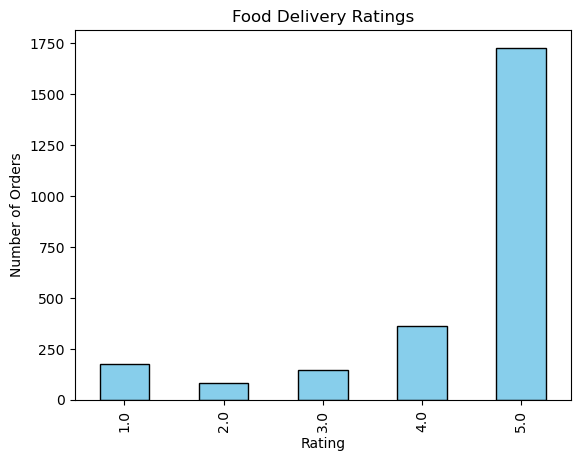

In [121]:
df['Rating'].value_counts().sort_index().plot(kind='bar', color='skyblue',edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Number of Orders")
plt.title("Food Delivery Ratings")
plt.show()

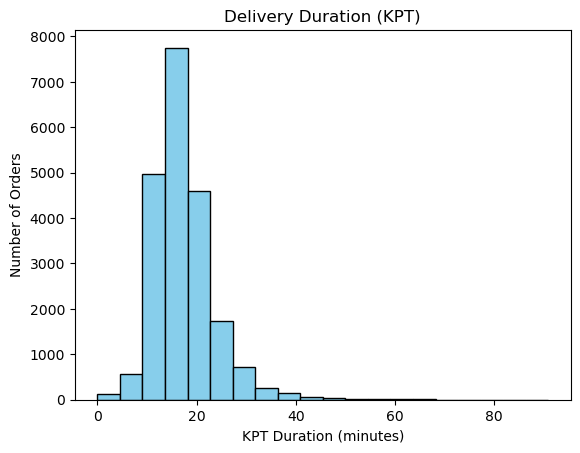

In [122]:
plt.hist(df['KPT duration (minutes)'],bins=20, color='skyblue', edgecolor='black')
plt.xlabel("KPT Duration (minutes)")
plt.ylabel("Number of Orders")
plt.title("Delivery Duration (KPT)")
plt.show()

In [123]:
df[to_predict].head()

,Distance,Items in order,Bill subtotal,Total,KPT duration (minutes),Rider wait time (minutes)
0,3km,"1 x Grilled Chicken Jamaican Tender, 1 x Grill...",715.0,666.75,18.35,11.6
1,2km,"1 x Peri Peri Fries, 1 x Fried Chicken Angara ...",1179.0,1054.20,16.95,3.6
2,<1km,1 x Bone in Peri Peri Grilled Chicken,310.0,241.50,14.05,12.2
3,2km,"1 x Fried Chicken Ghostbuster Tender, 1 x Anga...",620.0,567.00,19.00,3.3
4,2km,"1 x Peri Peri Krispers, 1 x Fried Chicken Anga...",584.0,529.20,15.97,1.0


In [124]:
df['KPT duration (minutes)'].fillna(df['KPT duration (minutes)'].median(), inplace=True)
df['Rider wait time (minutes)'].fillna(df['Rider wait time (minutes)'].median(), inplace=True)

df.loc[:, 'Items in order'] = df['Items in order'].apply(lambda x: len(str(x).split(','))) 
df.loc[:, 'Distance'] = df['Distance'].str.replace('<', '')
df.loc[:, 'Distance'] = df['Distance'].str.replace('km', '')

C:\Users\ivan0\AppData\Local\Temp\ipykernel_3500\1357154413.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['KPT duration (minutes)'].fillna(df['KPT duration (minutes)'].median(), inplace=True)
C:\Users\ivan0\AppData\Local\Temp\ipykernel_3500\1357154413.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

In [125]:
df[to_predict].isna().sum()

Distance                     0
Items in order               0
Bill subtotal                0
Total                        0
KPT duration (minutes)       0
Rider wait time (minutes)    0
dtype: int64

In [126]:
df = df.dropna(subset=['Rating'])
df['high_rating'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)

In [127]:
df['high_rating'].value_counts()

high_rating
1    2088
0     403
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

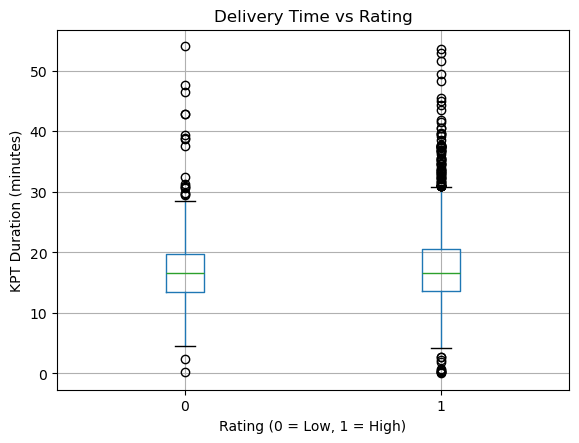

In [128]:
plt.figure()
df.boxplot(column='KPT duration (minutes)', by='high_rating')
plt.xlabel('Rating (0 = Low, 1 = High)')
plt.ylabel('KPT Duration (minutes)')
plt.title('Delivery Time vs Rating')
plt.suptitle('')
plt.show()

In [129]:
x = df[to_predict] 
y = df['high_rating'] 

In [130]:
x.head()

,Distance,Items in order,Bill subtotal,Total,KPT duration (minutes),Rider wait time (minutes)
3,2,2,620.0,567.00,19.00,3.3
5,1,2,715.0,666.75,20.48,1.0
12,3,1,310.0,220.50,17.23,8.8
22,5,2,524.0,466.20,16.88,13.3
32,3,1,695.0,645.75,7.87,4.7


In [131]:
y.value_counts()

high_rating
1    2088
0     403
Name: count, dtype: int64

In [132]:
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=67) 

In [133]:
rating_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced' 
) # [AI-Generated] suggested using class_weight='balanced' to address class imbalance
rating_model.fit(x_train,y_train) 

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [150]:
rating_model2 = LogisticRegression(
    max_iter=1000, 
    class_weight='balanced'
) # [AI-Generated] suggested using class_weight='balanced' to address class imbalance
rating_model2.fit(x_train,y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [156]:
## Using rfc 
y_pred = rating_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(cm)
print("F1 Score:", f1)

Accuracy: 0.8248663101604278
[[  1 130]
 [  1 616]]
F1 Score: 0.9038884812912693


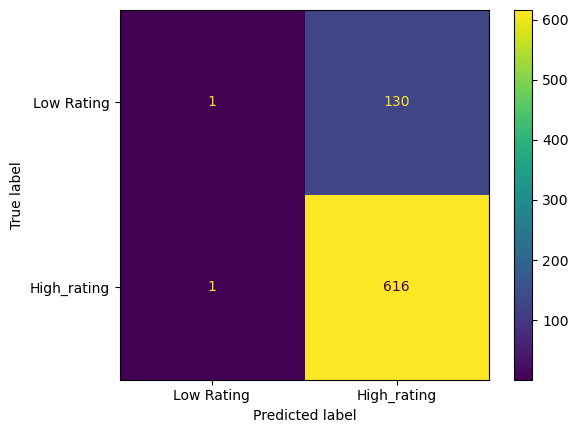

In [152]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Low Rating','High_rating'])

In [153]:
## Using lr
y_pred2 = rating_model2.predict(x_test)
accuracy = accuracy_score(y_test, y_pred2)
cm = confusion_matrix(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)
print("Accuracy:", accuracy)
print(cm)
print("F1 Score:", f1)

Accuracy: 0.5013368983957219
[[ 78  53]
 [320 297]]
F1 Score: 0.6142709410548087


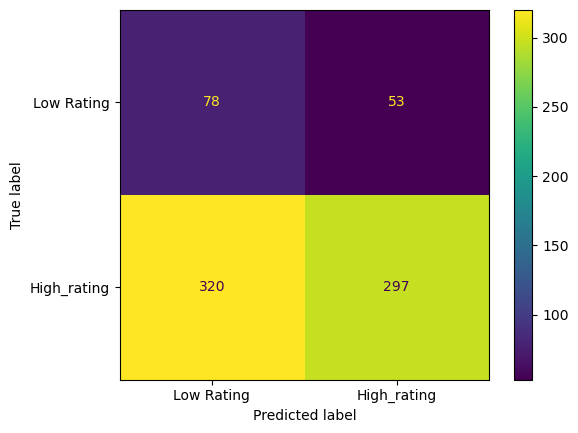

In [154]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred2,display_labels=['Low Rating','High_rating'])

In [155]:
# Model      Logistic Regression   Random Forest 
# Accuracy         51%                  82%      
# F1 Score         61%                  90%  

In [140]:
# [AI-Generated] Initial hyperparameter ranges suggested based on Random Forest best practices
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=67)

grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid.fit(x_train, y_train)
best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)

Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [141]:
joblib.dump(rating_model, "rating_model.joblib")

['rating_model.joblib']

In [142]:
rating_model = joblib.load("rating_model.joblib")

In [143]:
to_predict

['Distance',
 'Items in order',
 'Bill subtotal',
 'Total',
 'KPT duration (minutes)',
 'Rider wait time (minutes)']

In [157]:
def predict_rating(distance, items, bill, total, kpt, rider_wait):
    input_arr = np.array([[distance, items, bill, total, kpt, rider_wait]])
    prob_high = rating_model.predict_proba(input_arr)[0][1]
    # [AI-Generated] Suggested using a higher probability threshold to reduce false positives.
    pred = 1 if prob_high > 0.85 else 0
    return f"High Rating 👍 (Confidence: {prob_high:.2f})" if pred == 1 else f"Low Rating 👎 (Confidence: {1-prob_high:.2f})" 
inputs = [
    gr.Number(label="Distance (km)"),
    gr.Number(label="Items in Order"),
    gr.Number(label="Bill Subtotal"),
    gr.Number(label="Total Amount"),
    gr.Number(label="Duration (minutes)"),
    gr.Number(label="Rider Wait Time (minutes)")
]

outputs = gr.Textbox(label="Predicted Rating")

rating_app = gr.Interface(
    fn=predict_rating,
    inputs=inputs,
    outputs=outputs,
    title="Food Delivery Rating Predictor",
    description="Estimate whether an order will receive a high or low rating based on distance, price, and delivery duration."
)

# rating_app.launch()
rating_app.launch(share=True)


* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://590ef5d0f2e4ed35a7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
